In [49]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd

import os
import time

In [51]:
# 导入外部数据
data = pd.read_excel(os.path.join('./data', '温度和热源.xlsx'), engine='openpyxl')
xx = np.array(data['水平方向'])
yy = np.array(data['垂直方向'])
T = np.array(data['温度'])
G = np.array(data['热源'])

## 超参数设置

In [52]:
domain = (0, 0.25, 0, 0.25)
xmin, xmax, ymin, ymax = domain
mlp_layers = [2] + [80]*3 + [1]
mlp_layers_G = [2] + [20]*2 + [1]
# n_iters = 20000
n_iters = 5000
learning_rate = 5e-3
gamma = 0.6
N=101
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = r'./model'
train_info_path = r'./'
if not os.path.exists(model_path):
    os.mkdir(model_path)

lam_res = 1.
lam_obs = 1.

## 数据集生成

In [53]:
class Dataset:
    def __init__(self, domain):
        self.domain = domain
    
    def train_data(self, N=100, verbose=None):
        # 内部点
        # 导入外部数据

        # x_res = np.linspace(xmin, xmax, N)
        # y_res = np.linspace(ymin, ymax, N)
        # xx, yy = np.meshgrid(x_res, y_res)
        X_res = np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], axis=1)
        # G = self.G_func(X_res)
        # T = self.T_func(X_res)

        # 边界点
        observed_idx = np.concatenate([np.where(xx == xmin)[0], np.where(xx == xmax)[0], 
                                       np.where(yy == ymin)[0], np.where(yy == ymax)[0]], axis=0)
        X_obs = X_res[observed_idx]
        T_obs = T.reshape(-1,1)[observed_idx]
        # u_bcs = self.u_bcs_func(X_bcs)
        # T_data = temperature.reshape(-1, 1)[observed_idx]
        
        return X_res, X_obs,T_obs
    
    def G_func(self, X_res):
        G = np.sin(4 * np.pi * X_res[:,[0]]) * np.sin(4 * np.pi * X_res[:,[1]])
        return G
    
    def T_func(self, X_res):
        T = 1/(2 * (4 * np.pi)**2) * np.sin(4 * np.pi * X_res[:,[0]]) * np.sin(4 * np.pi * X_res[:,[1]])
        return T
    

dataset = Dataset(domain)
X_res, X_obs, T_obs = dataset.train_data()
print(X_res.shape, X_obs.shape)
# u_res.shape
T.shape,xx.shape

(10201, 2) (404, 2)


((10201,), (10201,))

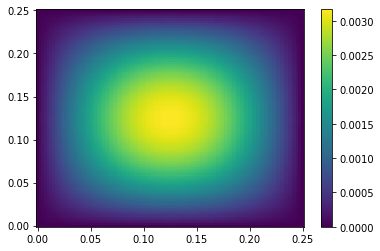

In [54]:
# T
plt.pcolor(xx.reshape(N,N), yy.reshape(N,N),T.reshape(N,N))
plt.colorbar()

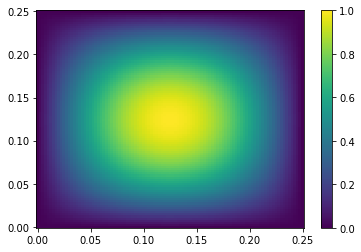

In [55]:
# G
plt.pcolor(X_res[:,[0]].reshape(N,N), X_res[:,[1]].reshape(N,N),G.reshape(N,N))
plt.colorbar()
# 小trick
T_D, T_M = (T.max() - T.min()), T.mean()
G_D, G_M = (G.max() - G.min()), G.mean()

In [56]:
# X = np.concatenate([X_res,X_obs],axis=0)
# U = np.concatenate([u_res,u_bcs],axis=0)
# # print()
# plt.scatter(X[:,0], X[:,1],c=U)
# plt.colorbar()
# u_D,u_M = (U.max() - U.min()),U.mean()


## PINN主干网络

In [57]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            self.model.add_module(f'fc{i+1}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            self.model.add_module(f'act{i+1}', nn.Tanh())
        self.model.add_module(f'fc{len(mlp_layers)-1})', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
    
    def forward(self, X):
        return self.model(X)
    
    
mlp = MLP(mlp_layers)
mlp_G = MLP(mlp_layers_G)
mlp.model

Sequential(
  (fc1): Linear(in_features=2, out_features=80, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=80, out_features=80, bias=True)
  (act2): Tanh()
  (fc3): Linear(in_features=80, out_features=80, bias=True)
  (act3): Tanh()
  (fc4)): Linear(in_features=80, out_features=1, bias=False)
)

## PINN模型

In [58]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

In [59]:
class PINN(nn.Module):
    def __init__(self, backbone, nn_G, mu=None, sigma=None):
        super(PINN, self).__init__()
        self.backbone = backbone
        self.nn_G = nn_G
        
        if mu is not None and sigma is not None:
            self.is_inputs_normalization = True
            self.mu = mu
            self.sigma = sigma
            print(f'forward with normalization, mu={self.mu.tolist()}, sigma={self.sigma.tolist()}')
        else:
            self.is_inputs_normalization = False
    
    def forward(self, X_res, X_obs, T_obs_data):
        f_res_pred = self.net_f(X_res)
        T_obs_pred = self.net_u(X_obs)
        f_res = torch.zeros((X_res.shape[0], 1))
        loss_res = torch.mean((f_res_pred - f_res) ** 2)
        loss_data = torch.mean((T_obs_pred - T_obs_data) ** 2)
        return loss_res, loss_data
    
    def net_u_output_transform(self, u):
        """对net_u输出做变换，若无需变换则直接return u"""
        return u * T_D / 2 + T_M

    def net_param_output_transform(self, param):
        """对net_param输出做变换，若无需变换则直接return param"""
        return param * G_D / 2 + G_M

    def net_u(self, X):
        if self.is_inputs_normalization == True:
            X = (X - self.mu) / self.sigma
        return self.net_u_output_transform(self.backbone(X))
    
    def net_G(self, X):
        if self.is_inputs_normalization == True:
            X = (X - self.mu) / self.sigma
        return self.net_param_output_transform(self.nn_G(X))
    
    def net_f(self, X):
        X.requires_grad_(True)
        T = self.net_u(X)

        # 求u的一阶导
        grad_u = self.grad(T, X)[0]
        u_x = grad_u[:, [0]]
        u_y = grad_u[:, [1]]
        # 求u的二阶导
        u_xx = self.grad(u_x, X)[0][:, [0]]
        u_yy = self.grad(u_y, X)[0][:, [1]]

        G = self.net_G(X)
        print(G.max())

        f_res_pred = u_xx + u_yy + G
        
        return f_res_pred
    
    @staticmethod
    def grad(outputs, inputs):
        return torch.autograd.grad(outputs, inputs,
                                   grad_outputs=torch.ones_like(outputs),
                                   create_graph=True)

pinn = PINN(mlp, mlp_G)

## Adam训练

In [60]:
# 训练
dataset = Dataset(domain)
X_res, X_obs, T_obs = dataset.train_data()
X_res = torch.from_numpy(X_res).float().to(device)
X_obs = torch.from_numpy(X_obs).float().to(device)
G = torch.from_numpy(G).float().to(device)
T = torch.from_numpy(T).float().to(device)
T_obs = torch.from_numpy(T_obs).float().to(device)

mu = X_res.mean(dim=0)
sigma = X_res.std(dim=0)  # 求样本标准差

backbone = MLP(mlp_layers)
nn_G = MLP(mlp_layers_G)
pinn = PINN(backbone, nn_G, mu, sigma)
pinn = pinn.to(device)

optimizer_adam = optim.Adam(pinn.backbone.parameters(), lr=learning_rate)
optimizer_adam_param = optim.Adam(pinn.nn_G.parameters(), lr=learning_rate)
# optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, 
# threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False
lr_sche = ReduceLROnPlateau(optimizer_adam, mode='min', factor=0.65, verbose=True)
lr_sche_param = ReduceLROnPlateau(optimizer_adam_param, mode='min', factor=0.75, verbose=True)

logger = {
    "loss": [],
    "loss_res": [],
    "loss_data": [],
    "iter": [],
    "mu": mu,
    "sigma": sigma
}
best_loss = 1e9

with open(train_info_path + 'train_info.txt', 'w') as f:
    f.write('Training by Adam:\n')
start_time = time.time()

for it in range(n_iters):
    pinn.zero_grad()
    loss_res, loss_data = pinn(X_res, X_obs, T_obs)

    # 小trick

    if it == 0:
        scale_res = loss_res.detach().cpu().numpy().item()
        scale_data = loss_data.detach().cpu().numpy().item()
        print(f'standardize loss, sclae_res={scale_res}, sclae_obs={scale_data}')
    else:
        loss_res = loss_res / scale_res
        loss_data = loss_data / scale_data

    loss = lam_res * loss_res + lam_obs * loss_data
#     loss = 100*loss_res + loss_data
    loss.backward()
    optimizer_adam.step()
    optimizer_adam_param.step()
    
    # 保存训练信息 -------
    logger["loss"].append(loss.item())
    logger["loss_res"].append(loss_res.item())
    logger["loss_data"].append(loss_data.item())
    logger["iter"].append(it + 1)
    
    if (it + 1) % 100 == 0:  # 打印训练信息 -------
        info = f'Iter # {it+1:4d}/{n_iters}\ttime:{time.time()-start_time:.1f}\t' + f'loss:{loss.item():.2e}, loss_r:{loss_res.item():.2e}, loss_d:{loss_data.item():.2e}'
        with open(train_info_path + 'train_info.txt', 'a') as f:
            f.write(info + '\n')
        print(info)
        if loss.item() < best_loss:
            model_state = {
                'iter': it,
                'backbone_state': pinn.backbone.state_dict(),
                'nn_G_state': pinn.nn_G.state_dict(),
            }
            torch.save(model_state, os.path.join(model_path, 'model_adam.pth'))
            best_loss = loss.item()
        # print(pinn.net_f(X_res).max())
        # print(T.max())
        # print(pinn.net_G(X_res).max())
        # print(G.max())

    if (it + 1) % 100 == 0:  # 学习率衰减 -------
        lr_sche.step(loss)
        lr_sche_param.step(loss)

forward with normalization, mu=[0.125, 0.125], sigma=[0.07289046794176102, 0.07289046794176102]
tensor(0.4541, grad_fn=<MaxBackward1>)
standardize loss, sclae_res=0.12383679300546646, sclae_obs=1.4080685559747508e-06


tensor(0.4061, grad_fn=<MaxBackward1>)
tensor(0.3638, grad_fn=<MaxBackward1>)
tensor(0.3169, grad_fn=<MaxBackward1>)
tensor(0.2671, grad_fn=<MaxBackward1>)
tensor(0.2188, grad_fn=<MaxBackward1>)
tensor(0.1776, grad_fn=<MaxBackward1>)
tensor(0.1349, grad_fn=<MaxBackward1>)
tensor(0.0925, grad_fn=<MaxBackward1>)
tensor(0.0530, grad_fn=<MaxBackward1>)
tensor(0.0196, grad_fn=<MaxBackward1>)
tensor(-0.0046, grad_fn=<MaxBackward1>)
tensor(-0.0186, grad_fn=<MaxBackward1>)
tensor(-0.0232, grad_fn=<MaxBackward1>)
tensor(-0.0201, grad_fn=<MaxBackward1>)
tensor(-0.0112, grad_fn=<MaxBackward1>)
tensor(0.0016, grad_fn=<MaxBackward1>)
tensor(0.0169, grad_fn=<MaxBackward1>)
tensor(0.0333, grad_fn=<MaxBackward1>)
tensor(0.0498, grad_fn=<MaxBackward1>)
tensor(0.0655, grad_fn=<MaxBackward1>)
tensor(0.0795, grad_fn=<MaxBackward1>)
tensor(0.0915, grad_fn=<MaxBackward1>)
tensor(0.1012, grad_fn=<MaxBackward1>)
tensor(0.1084, grad_fn=<MaxBackward1>)
tensor(0.1132, grad_fn=<MaxBackward1>)
tensor(0.1159, grad_

KeyboardInterrupt: 

In [ ]:
# plt.hist(pinn.net_f(X_res).detach().cpu().numpy())

In [ ]:
# # 保存模型参数 训练记录
# model_state = {'iter': it+1, 'backbone_state': pinn.backbone.state_dict(),'nn_G_state': pinn.nn_G.state_dict()}
# backbone_path = os.path.join(model_path, f'backbone_adam.pth')
# torch.save(model_state, backbone_path)

np.save("./loss_logger_dict.npy", logger)

In [ ]:
# 训练用时
def used_time(start_time):
    seconds = time.time() - start_time
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    print(f'used time: {hours:.0f}h {minutes:.0f}m {seconds:.0f}s')
    
used_time(start_time)

used time: 0h 22m 38s


## 结果可视化

In [ ]:
plt.rcParams.update({'font.size':18})

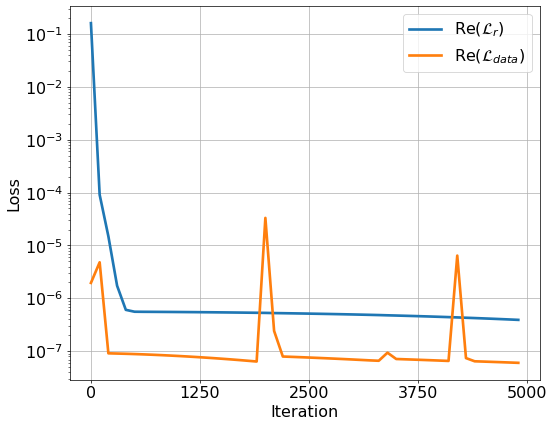

In [ ]:
# loss曲线
loss_logger = np.load("./loss_logger_dict.npy", allow_pickle=True).item()

fig = plt.figure(figsize=(9, 7), dpi=64)
ax = fig.subplots()

k_plot = 100
# ax.plot(loss_logger["iter"][::k], loss_logger["loss"][::k], label=r"$\mathcal{L}$", linewidth=3)
ax.plot(loss_logger["iter"][::k_plot], loss_logger["loss_res"][::k_plot], label=r"Re($\mathcal{L}_{r})$", linewidth=3)
ax.plot(loss_logger["iter"][::k_plot], loss_logger["loss_data"][::k_plot], label=r"Re($\mathcal{L}_{data})$", linewidth=3)
ax.set_yscale('log')
ax.set_xticks(np.linspace(0, loss_logger["iter"][-1], 5))
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.grid()

ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('Loss.png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
# 导入模型参数
mu = logger["mu"].cpu()
sigma = logger["sigma"].cpu()

backbone = MLP(mlp_layers)
nn_G = MLP(mlp_layers_G)
pinn = PINN(backbone, nn_G, mu, sigma)
model_state = torch.load(os.path.join(model_path, 'model_adam.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_G.load_state_dict(model_state['nn_G_state'])
pinn.eval()

forward with normalization, mu=[0.125, 0.125], sigma=[0.07289046794176102, 0.07289046794176102]


PINN(
  (backbone): MLP(
    (model): Sequential(
      (fc1): Linear(in_features=2, out_features=80, bias=True)
      (act1): Tanh()
      (fc2): Linear(in_features=80, out_features=80, bias=True)
      (act2): Tanh()
      (fc3): Linear(in_features=80, out_features=80, bias=True)
      (act3): Tanh()
      (fc4)): Linear(in_features=80, out_features=1, bias=False)
    )
  )
  (nn_G): MLP(
    (model): Sequential(
      (fc1): Linear(in_features=2, out_features=20, bias=True)
      (act1): Tanh()
      (fc2): Linear(in_features=20, out_features=20, bias=True)
      (act2): Tanh()
      (fc3)): Linear(in_features=20, out_features=1, bias=False)
    )
  )
)

In [ ]:
def func_G( X_res):
        G = np.sin(4 * np.pi * X_res[:,[0]]) * np.sin(4 * np.pi * X_res[:,[1]])
        return G
    
def func_T( X_res):
    T = 1/(2 * (4 * np.pi)**2) * np.sin(4 * np.pi * X_res[:,[0]]) * np.sin(4 * np.pi * X_res[:,[1]])
    return T

dataset = Dataset(domain)
X_res, X_obs, T_obs = dataset.train_data(N=100)
X_res = torch.from_numpy(X_res).float().to(device)
X_obs = torch.from_numpy(X_obs).float().to(device)
# G = torch.from_numpy(G).float().to(device)
# T = torch.from_numpy(T).float().to(device)
# T_obs = torch.from_numpy(T_obs).float().to(device)

In [ ]:
# X_res= X_res.cpu().detach().numpy()
# X_obs= X_obs.cpu().detach().numpy()
# X = np.concatenate([X_res,X_obs],axis=0)
# X = torch.from_numpy(X)
# X = X.reshape(-1, 1)
# X_res = torch.from_numpy(X_res).float().to(device)
G_star = func_G(X_res)
G_pred = pinn.net_G(X_res).detach()

T_star = func_T(X_res)
T_pred = pinn.net_u(X_res).detach()

G_error = np.linalg.norm(G_pred - G_star) / np.linalg.norm(G_star)
T_error = np.linalg.norm(T_pred - T_star) / np.linalg.norm(T_star)

print('Relative l2 error of G: {:.3e}'.format(G_error))
print('Relative l2 error of T: {:.3e}'.format(T_error))

Relative l2 error of G: 1.001e+00
Relative l2 error of T: 1.000e+00


In [ ]:
x = X_res[:,[0]]
y = X_res[:,[1]]
XX, YY = np.meshgrid(x, y)
XY = np.concatenate([XX.reshape(-1,1), YY.reshape(-1,1)], axis=1)
XY = torch.from_numpy(XY)

RuntimeError: shape '[100, 100]' is invalid for input of size 10201

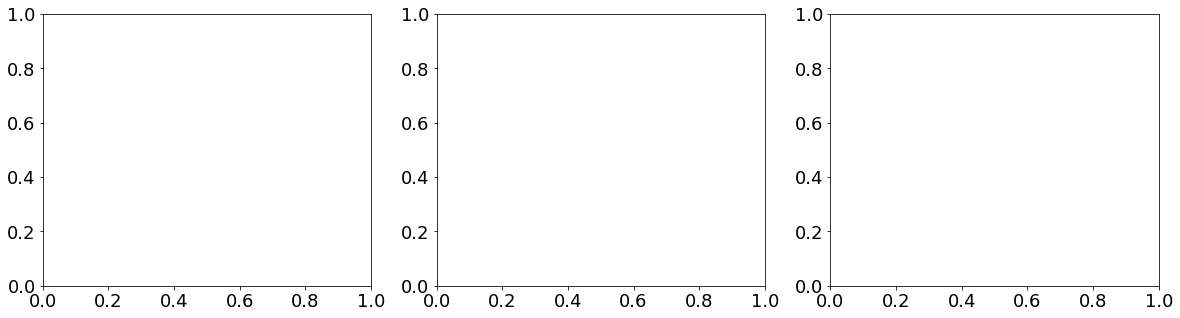

In [ ]:
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

cax1 = axes[0].pcolor(X_res[:,[0]].reshape(100,100), X_res[:,[1]].reshape(100,100), G_star.reshape(100,100))
fig.colorbar(cax1)
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].set_title(r'Reference $u(t,x)$')

axes[0].set_aspect(1./axes[0].get_data_ratio())

cax2 = axes[1].pcolor(X_res[:,[0]].reshape(100,100), X_res[:,[1]].reshape(100,100), G_pred.reshape(100,100))
fig.colorbar(cax2)
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].set_title(r'Predicted $u(t,x)$')
axes[1].set_aspect(1./axes[1].get_data_ratio())

cax3 = axes[2].pcolor(X_res[:,[0]].reshape(100,100), X_res[:,[1]].reshape(100,100), np.abs(G_star - G_pred).reshape(100,100))
fig.colorbar(cax3)
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')
axes[2].set_title('Absolute error')
axes[2].set_aspect(1./axes[2].get_data_ratio())

plt.tight_layout()
plt.savefig('Burgers_result.png', dpi=100, bbox_inches='tight')
plt.show()

<ipython-input-25-6243d9cb986d>:5: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(cax1)
<ipython-input-25-6243d9cb986d>:13: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(cax2)


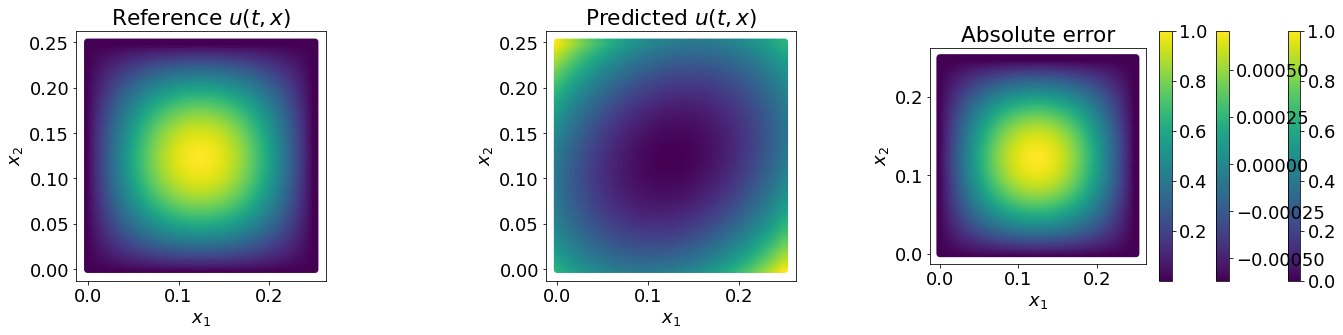

In [ ]:
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

cax1 = axes[0].scatter(X_res[:,[0]], X_res[:,[1]], c=G_star)
fig.colorbar(cax1)
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].set_title(r'Reference $u(t,x)$')

axes[0].set_aspect(1./axes[0].get_data_ratio())

cax2 = axes[1].scatter(X_res[:,[0]], X_res[:,[1]], c=G_pred)
fig.colorbar(cax2)
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].set_title(r'Predicted $u(t,x)$')
axes[1].set_aspect(1./axes[1].get_data_ratio())

cax3 = axes[2].scatter(X_res[:,[0]], X_res[:,[1]], c=np.abs(G_star - G_pred))
fig.colorbar(cax3)
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')
axes[2].set_title('Absolute error')
axes[2].set_aspect(1./axes[2].get_data_ratio())

plt.tight_layout()
plt.savefig('Burgers_result.png', dpi=100, bbox_inches='tight')
plt.show()

<ipython-input-107-681aa470609e>:5: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(cax1)
<ipython-input-107-681aa470609e>:13: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(cax2)


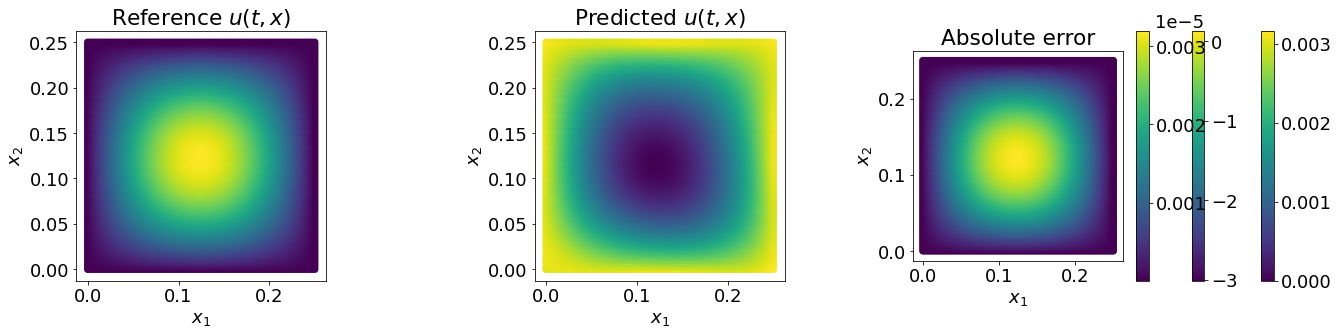

In [ ]:
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

cax1 = axes[0].scatter(X_res[:,[0]], X_res[:,[1]], c=T_star)
fig.colorbar(cax1)
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].set_title(r'Reference $u(t,x)$')

axes[0].set_aspect(1./axes[0].get_data_ratio())

cax2 = axes[1].scatter(X_res[:,[0]], X_res[:,[1]], c=T_pred)
fig.colorbar(cax2)
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].set_title(r'Predicted $u(t,x)$')
axes[1].set_aspect(1./axes[1].get_data_ratio())

cax3 = axes[2].scatter(X_res[:,[0]], X_res[:,[1]], c=np.abs(T_star - T_pred))
fig.colorbar(cax3)
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')
axes[2].set_title('Absolute error')
axes[2].set_aspect(1./axes[2].get_data_ratio())

plt.tight_layout()
plt.savefig('Burgers_result.png', dpi=100, bbox_inches='tight')
plt.show()

<ipython-input-78-26c424799c62>:6: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar1 = fig.colorbar(cax1)
<ipython-input-78-26c424799c62>:20: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar2 = fig.colorbar(cax2)


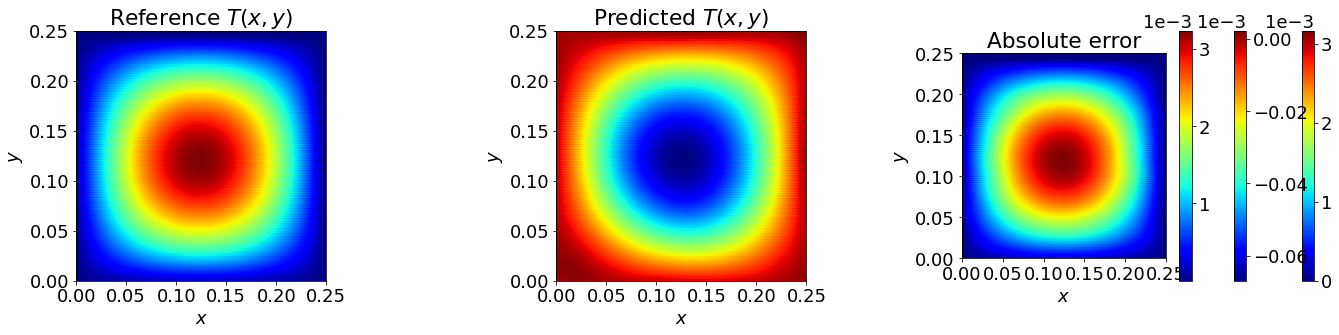

In [ ]:
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

ax = axes[0]
cax1 = ax.scatter(X_res[:,[0]], X_res[:,[1]], c=T, s=100, cmap='jet')
cbar1 = fig.colorbar(cax1)
cbar1.formatter.set_powerlimits((-3, -3))
cbar1.update_ticks()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Reference $T(x,y)$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

ax = axes[1]
cax2 = ax.scatter(X_res[:,[0]], X_res[:,[1]], c=T_pred, s=100, cmap='jet')
cbar2 = fig.colorbar(cax2)
cbar2.formatter.set_powerlimits((-3, -3))
cbar2.update_ticks()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Predicted $T(x,y)$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

ax = axes[2]
cax3 = ax.scatter(X_res[:,[0]], X_res[:,[1]], c=abs(T - T_pred), s=100, cmap='jet')
cbar3 = fig.colorbar(cax3)
cbar3.formatter.set_powerlimits((0, 0))
cbar3.update_ticks()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Absolute error')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()
# plt.savefig(os.path.join(figure_path, 'T.png'), dpi=64, bbox_inches='tight')
plt.show()

<ipython-input-79-ea31cbeb2111>:6: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar1 = fig.colorbar(cax1)
<ipython-input-79-ea31cbeb2111>:20: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar2 = fig.colorbar(cax2)


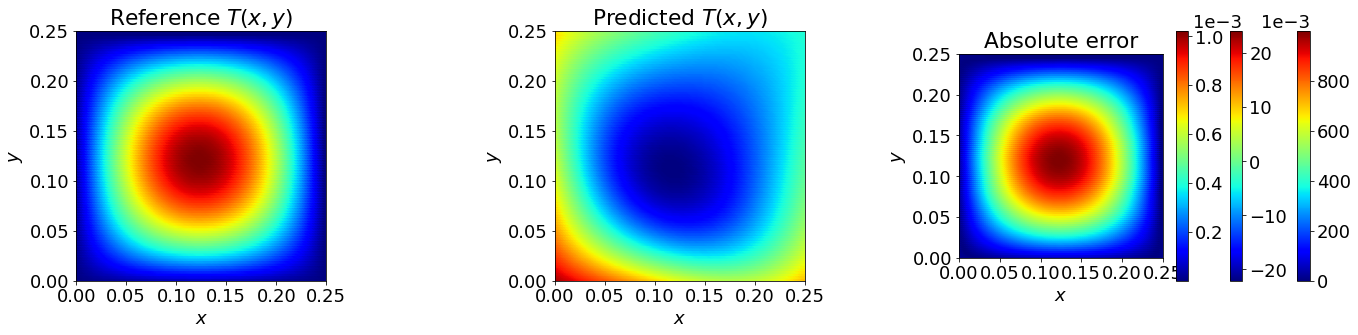

In [ ]:
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

ax = axes[0]
cax1 = ax.scatter(X_res[:,[0]], X_res[:,[1]], c=G, s=100, cmap='jet')
cbar1 = fig.colorbar(cax1)
cbar1.formatter.set_powerlimits((-3, -3))
cbar1.update_ticks()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Reference $T(x,y)$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

ax = axes[1]
cax2 = ax.scatter(X_res[:,[0]], X_res[:,[1]], c=G_pred, s=100, cmap='jet')
cbar2 = fig.colorbar(cax2)
cbar2.formatter.set_powerlimits((-3, -3))
cbar2.update_ticks()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Predicted $T(x,y)$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

ax = axes[2]
cax3 = ax.scatter(X_res[:,[0]], X_res[:,[1]], c=abs(G_star - G_pred), s=100, cmap='jet')
cbar3 = fig.colorbar(cax3)
cbar3.formatter.set_powerlimits((0, 0))
cbar3.update_ticks()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Absolute error')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()
# plt.savefig(os.path.join(figure_path, 'T.png'), dpi=64, bbox_inches='tight')
plt.show()